In [1]:
## This code was inspired from the orginal Pix2Pix implementation by tensorflow (https://www.tensorflow.org/tutorials/generative/pix2pix) and Sam Maddrell-Mander(https://towardsdatascience.com/pix2pix-gan-in-tensorflow-2-0-fe0ab475c713)

!pip install git+https://github.com/alessiogmonti/visualkeras
import tensorflow as tf
from tensorflow.python import training
import visualkeras

import os
import glob
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/alessiogmonti/visualkeras to /tmp/pip-req-build-jzs5vetq
  Running command git clone -q https://github.com/alessiogmonti/visualkeras /tmp/pip-req-build-jzs5vetq
     |████████████████████████████████| 992 kB 8.4 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13033 sha256=d41635dd50aef5ac58cec628f8a61620e5e8c6cd4638c5dfd5da53b33221f523
  Stored in directory: /tmp/pip-ephem-wheel-cache-ksgm_5td/wheels/8c/98/da/cd792cfaef8538e6921280cf1070358a4c09e7c50569f5bc69
Successfully built visualkeras


In [2]:
problem = "Cantilever" #@param ["MMB", "Cantilever"]
method = 'UNet'

In [3]:
## Note: Please double chech the paths to the respective dataset.
print("Note: Please double chech the paths to the respective dataset !!")
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/'
if problem == 'MMB':
  path = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Dataset/topopt_1000_resized/'
  BUFFER_SIZE = 1472 # Size of the traning dataset
elif problem == 'Cantilever':
  path = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Dataset/Canti_resized/'
  BUFFER_SIZE = 836 # Size of the traning dataset
else:
  path = input("Enter path to traning and validation data: ")
print('Path: ', path)
train_path = path  + 'train/'
test_path = path + 'val/'
movie_path = path + 'topopt_1000_resized/moving_load/'
save_model = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix/Models/'

%cd '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path:  /content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Dataset/Canti_resized/
/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix


In [4]:
EPOCHS = int(input("Enter the number of Epochs: "))
BATCH_SIZE = int(input("Enter the Batch Size: ")) # Batch size of 1 was recomended in the Pix2Pix paper.

IMG_WIDTH = 256 # Width of the traning image    
IMG_HEIGHT = 256 # Height of the traning image

Enter the number of Epochs: 200
Enter the Batch Size: 1


In [5]:
def plot_losses(g_loss, d_loss, epoch, dataset, base_path='results/'):
    if not os.path.exists(base_path):
      os.makedirs(base_path)
    total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    d_loss = [d[0].numpy() for d in d_loss]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(d_loss, label='disc')
    plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.savefig(base_path + '/losses.png')
    plt.close()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    xs = [_ for _ in range(len(d_loss))]
    if len(xs) > 20:
        window=5
        f, axarr = plt.subplots(2, figsize=(8,4), sharex=True)
        axarr[0].plot(d_loss, alpha=0.4, linewidth=5)
        axarr[0].plot(xs[window:-window], smooth(d_loss, window)[window:-window], c='C0')
        axarr[0].set_title('Discriminator')
        axarr[0].set_yscale('log')
        axarr[0].set_ylabel('loss')
        axarr[1].plot(g_loss, alpha=0.4, linewidth=5)
        axarr[1].plot(xs[window:-window], smooth(g_loss, window)[window:-window], c='C1')
        axarr[1].set_title('Generator')
        axarr[1].set_xlabel('Epoch')
        axarr[1].set_ylabel('loss')
        plt.savefig(base_path + '/loss_tracking.png')
        plt.close()

In [6]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image


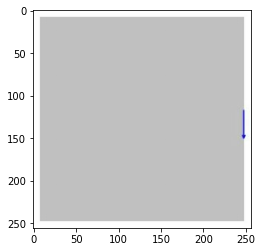

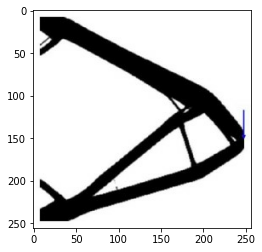

In [7]:
if problem == 'MMB':
  re, inp = load(path + 'train/6-0,497.jpg')
else:  
  re, inp = load(path + 'train/151-0,244.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.show()
plt.figure()
plt.imshow(re/255.0)
plt.show()


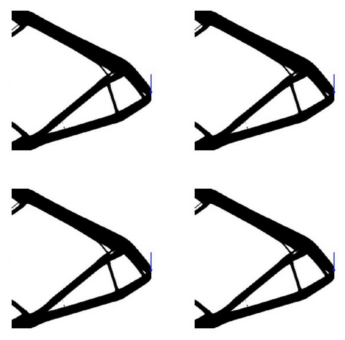

In [8]:

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  a = input_image
  b = real_image
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return a, b

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_re/255.0)
  plt.axis('off')
plt.show()

def load_image_train(image_file):
  real_image, input_image= load(image_file)
  real_image, input_image = random_jitter(real_image, input_image)
  real_image, input_image = normalize(real_image, input_image)

  return input_image, real_image

def load_image_test(image_file):
  real_image, input_image = load(image_file)
  real_image, input_image = resize(real_image, input_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  real_image, input_image = normalize(real_image, input_image)

  return input_image, real_image

def load_image_moving(image_file):
  real_image, input_image = load(image_file)
  real_image, input_image = resize(real_image, input_image, IMG_HEIGHT, IMG_WIDTH)
  real_image, input_image = normalize(real_image, input_image)
  return input_image, real_image



In [9]:
"""## Input Pipeline"""

# train_dataset = tf.data.Dataset.list_files(path + 'train/*.jpg') For MMB Beams
train_dataset = tf.data.Dataset.list_files(path + 'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(path + 'val/*.jpg')

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


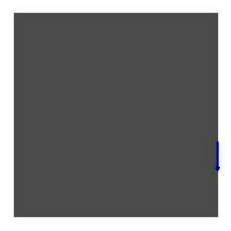

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


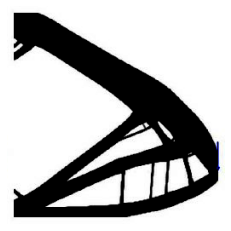

In [10]:
for a, b in train_dataset.take(1): #Take subsets the dataset into at most __1__ element (Seems to randomly create it)
  plt.figure()
  plt.imshow(tf.squeeze(a, [0]))
  plt.axis('off')
  plt.show()
  plt.figure()
  plt.imshow(tf.squeeze(b, [0]))
  plt.axis('off')
  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


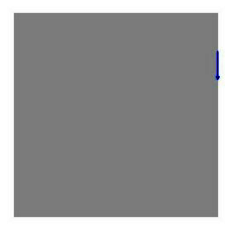

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


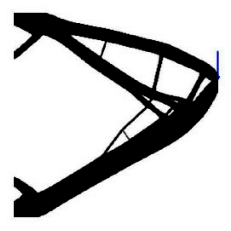

In [11]:
for a, b in test_dataset.take(1): #Take subsets the dataset into at most __1__ element (Seems to randomly create it)
  plt.figure()
  plt.imshow(tf.squeeze(a, [0]))
  plt.axis('off')
  plt.show()
  plt.figure()
  plt.imshow(tf.squeeze(b, [0]))
  plt.axis('off')
  plt.show()

In [12]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)
# (1, 128, 128, 3)


(1, 128, 128, 3)


In [13]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

# (1, 256, 256, 3)

(1, 256, 256, 3)


In [14]:
class Generator_(tf.keras.Model):

    def __init__(self,):
        super(Generator_, self).__init__()
        self.downsample = [downsample(64, 4, apply_batchnorm=False),
                           downsample(128, 4),  # (bs, 64, 64, 128)
                           downsample(256, 4),  # (bs, 32, 32, 256)
                           downsample(512, 4),  # (bs, 16, 16, 512)
                           downsample(512, 4),  # (bs, 8, 8, 512)
                           downsample(512, 4),  # (bs, 4, 4, 512)
                           downsample(512, 4), # (bs, 2, 2, 512)
                           downsample(512, 4)]  # (bs, 1, 1, 512)

        self.upsample = [upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
                         upsample(512, 4),  # (bs, 16, 16, 1024)
                         upsample(256, 4),  # (bs, 32, 32, 512)
                         upsample(128, 4),  # (bs, 64, 64, 256)
                         upsample(64, 4)]  # (bs, 128, 128, 128)

        initializer = tf.random_normal_initializer(0., 0.02)
        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                                    strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer,
                                                    activation='tanh') # (bs, 256, 256, 3)
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs, training=False):
        """Define the forward pass."""
        # print("Input: ", tf.shape(inputs))
        x = inputs
        # print(tf.shape(x))
        # Downsampling through the model
        skips = []
        # print("Down")
        for down in self.downsample:
          x = down(x)
          # print(tf.shape(x))
          skips.append(x)
          # print(tf.shape(x))
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        # print("Up")
        for up, skip in zip(self.upsample, skips):
          x = up(x)
          # print("Before : ", tf.shape(x))
          # print()

          x = self.concat([x, skip])
          # print("After :", tf.shape(x), tf.shape(skip))

        return self.last(x)





generator = Generator_()


gen_output = generator(inp[tf.newaxis,...], training=False)
generator.summary()

# plt.imshow(gen_output[0,...])
# plt.figure()
# output = tf.squeeze(gen_output, [0])
# plt.imshow(output)
# plt.show()

# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


Model: "generator_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 128, 128, 64)         3072      
                                                                 
 sequential_3 (Sequential)   (1, 64, 64, 128)          131584    
                                                                 
 sequential_4 (Sequential)   (1, 32, 32, 256)          525312    
                                                                 
 sequential_5 (Sequential)   (1, 16, 16, 512)          2099200   
                                                                 
 sequential_6 (Sequential)   (1, 8, 8, 512)            4196352   
                                                                 
 sequential_7 (Sequential)   (1, 4, 4, 512)            4196352   
                                                                 
 sequential_8 (Sequential)   (1, 2, 2, 512)            4

In [15]:
class Discriminator_(tf.keras.Model):
    def __init__(self,):
        super(Discriminator_, self).__init__()

        initializer = tf.random_normal_initializer(0., 0.02)
        self.down1 = downsample(64, 4, False)
        self.down2 = downsample(128, 4)
        self.down3 = downsample(256, 4)
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                      kernel_initializer=initializer,
                                      use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                           kernel_initializer=initializer)

    def call(self, inputs, target, training=False):

        x = tf.keras.layers.concatenate([inputs, target])
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last(x)
discriminator = Discriminator_()
disc_out = discriminator(inp[tf.newaxis,...], gen_output, training=False)
# plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()
# plt.show()


In [16]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



In [25]:
## Checkpoints

checkpoint_dir = './training_checkpoints_{}_{}_{}'.format(problem, EPOCHS, BATCH_SIZE)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [19]:
def generate_images(model, test_input, tar, base_path='', epoch=0):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  if not os.path.exists(base_path):
    os.makedirs(base_path)

  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,8))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.close()


In [20]:

@tf.function
def train_step(input_image, target, g_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator(input_image, target, training=True)
    disc_generated_output = discriminator(input_image, gen_output, training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Update the metrics
  g_loss_metric.update_state(gen_loss)
  d_loss_metric.update_state(disc_loss)
  # accuracy_metric.update_state(tf.ones_like(gen_output), gen_output)
  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [21]:
def train(dataset, epochs):
  bs = dataset.batch(BATCH_SIZE)
  # Create the metrics
  g_loss_log = []
  d_loss_log = []
  g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
  d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  for epoch in range(epochs):
    start = time.time()
    g_loss_metric.reset_states()
    d_loss_metric.reset_states()
    counter = 0
    for input_image, target in dataset:
      # print("Image Size : ", tf.shape(input_image))
      train_step(input_image, target, g_loss_metric, d_loss_metric)
      counter += 1
      if counter > 100:
        break
    g_mean_loss = g_loss_metric.result()
    d_mean_loss = d_loss_metric.result()
    g_loss_log.append([g_mean_loss])
    d_loss_log.append([d_mean_loss])

    print('Epoch: ', epoch)
    print('  loss (g) (d) (g+d):     {:.3f}, {:.3f}, {:.3f}'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))

    if (epoch) % 10 == 0:
      for i, (inp, tar) in enumerate(test_dataset.take(5)):
        generate_images(generator, inp, tar, base_path='results_{}_{}_{}/{}'.format(problem, EPOCHS, BATCH_SIZE, i), epoch=epoch)
        plot_losses(g_loss_log, d_loss_log, epoch=epoch, dataset='dataset', base_path='results_{}_{}_{}'.format(problem, EPOCHS, BATCH_SIZE))

    # Saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
    
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))


In [ ]:
start_time = time.time()
train(train_dataset, EPOCHS)
end_time = time.time()
print("Average Time Taken per Epoch: ", (end_time - start_time)/EPOCHS)
generator.save(filepath=save_model + '/{}/UNet_Generator'.format(problem), save_format="tf")


Epoch:  0
  loss (g) (d) (g+d):     52.266, 0.514, 52.780
Time taken for epoch 1 is 31.46886968612671 sec

Epoch:  1
  loss (g) (d) (g+d):     30.860, 0.457, 31.317
Time taken for epoch 2 is 23.15750479698181 sec

Epoch:  2
  loss (g) (d) (g+d):     24.795, 0.479, 25.274
Time taken for epoch 3 is 22.98745822906494 sec

Epoch:  3
  loss (g) (d) (g+d):     20.471, 0.628, 21.099
Time taken for epoch 4 is 23.19956684112549 sec

Epoch:  4
  loss (g) (d) (g+d):     16.930, 0.780, 17.710
Time taken for epoch 5 is 22.769164085388184 sec

Epoch:  5
  loss (g) (d) (g+d):     15.849, 0.945, 16.794
Time taken for epoch 6 is 23.127909898757935 sec

Epoch:  6
  loss (g) (d) (g+d):     14.861, 0.800, 15.661
Time taken for epoch 7 is 22.7881076335907 sec

Epoch:  7
  loss (g) (d) (g+d):     14.382, 0.927, 15.309
Time taken for epoch 8 is 23.06738042831421 sec

Epoch:  8
  loss (g) (d) (g+d):     13.542, 0.947, 14.489
Time taken for epoch 9 is 22.942085027694702 sec

Epoch:  9
  loss (g) (d) (g+d):    

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [30]:

def test_gen(ctr, model, test_inp, test_tar, savepath = 'performance_30/{}_{}'.format(problem, method)):
  if not os.path.exists(savepath):
    os.makedirs(savepath)
  prediction = model(test_inp, training=True)
  plt.figure(figsize=(15,8))

  display_list = [test_inp[0], test_tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  for i in range(3):

    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  # plt.show()
  plt.savefig(savepath + '/result_test1{}.png'.format(ctr))
  plt.close()


In [32]:
"""## Testing on the entire test dataset"""
ctr = 0
for inp, tar in test_dataset.take(4):
  test_gen(ctr, generator, inp, tar)
  ctr +=1